In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU 
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Flatten, Reshape

In [2]:
# Load the MNIST dataset
(x_train, _),(_ , _) = keras.datasets.mnist.load_data()

# Reshape the data to (28,28,1)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')

# Normalize the data to [-1,1]
x_train = (x_train - 127.5) / 127.5

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
x_train.shape

(60000, 28, 28, 1)

In [4]:
# Define Hyperparameters
epochs = 100
batch_size = 128
noise_dim = 100
num_examples_to_generate = 16

In [5]:
# Create object for the MNIST dataset
data = tf.data.Dataset.from_tensor_slices(x_train)
data = data.shuffle(buffer_size=1024).batch(batch_size)

In [6]:
# Create the Generator
def generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())  

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False,activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [7]:
# Create the Discriminator
def discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [8]:
# Create object from generator_model & discriminator_model
generator = generator_model()
discriminator = discriminator_model()

# Define the loss functions for the generator & discriminator
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Create the Generator Loss
def generator_loss(fake_image):
    return cross_entropy(tf.ones_like(fake_image), fake_image)

In [10]:
# Create the Discriminator Loss
def discriminator_loss(real_image, fake_image):
    real_loss = cross_entropy(tf.ones_like(real_image), real_image)
    fake_loss = cross_entropy(tf.zeros_like(fake_image), fake_image)
    total_loss = real_loss + fake_loss
    return total_loss

In [11]:
# Define the optimizers for the generator and discriminator
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer =  keras.optimizers.Adam(1e-4)

In [12]:
# Define the training loop
def train_step(images):
    # Generating noise from a normal distribution
    fake_img_noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(fake_img_noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
         
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        print("gen_loss", np.mean(gen_loss))
        print("disc_loss", np.mean(disc_loss))

In [13]:
# Train the GAN
def train(data, epochs):
    for epoch in range(epochs):
        for batch in data:
            train_step(batch)

# Training the GAN model
train(data, epochs)

gen_loss 0.67613447
disc_loss 1.3801332
gen_loss 0.65381783
disc_loss 1.362275
gen_loss 0.63182855
disc_loss 1.3488309
gen_loss 0.6178477
disc_loss 1.3270727
gen_loss 0.602908
disc_loss 1.3180976
gen_loss 0.59470886
disc_loss 1.2925026
gen_loss 0.5848735
disc_loss 1.2768817
gen_loss 0.5826129
disc_loss 1.2485355
gen_loss 0.57418525
disc_loss 1.235289
gen_loss 0.57359236
disc_loss 1.219748
gen_loss 0.56590885
disc_loss 1.1987451
gen_loss 0.566804
disc_loss 1.1830318
gen_loss 0.5702047
disc_loss 1.1653934
gen_loss 0.56376076
disc_loss 1.1558539
gen_loss 0.5637492
disc_loss 1.1371628
gen_loss 0.55501544
disc_loss 1.1323882
gen_loss 0.5556116
disc_loss 1.1314579
gen_loss 0.5494685
disc_loss 1.1258862
gen_loss 0.5441017
disc_loss 1.1165342
gen_loss 0.53311473
disc_loss 1.1273484
gen_loss 0.5238005
disc_loss 1.142338
gen_loss 0.51176834
disc_loss 1.14889
gen_loss 0.5046954
disc_loss 1.156843
gen_loss 0.48598582
disc_loss 1.1847976
gen_loss 0.47922868
disc_loss 1.1992663
gen_loss 0.46733725
d

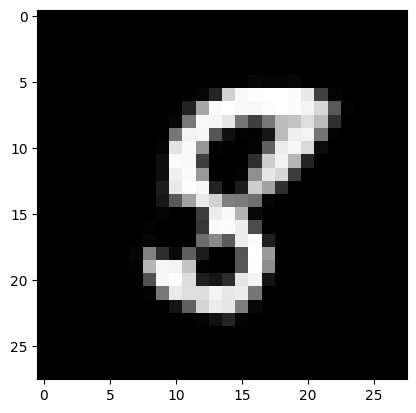

In [14]:
plt.imshow(generator(np.random.randn(1, 100)).numpy().reshape(28, 28), cmap='gray')

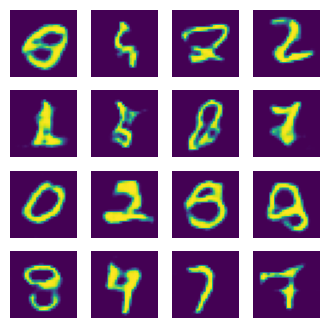

In [15]:
# Generate some fake images using by trained generator
noise = tf.random.normal([num_examples_to_generate, noise_dim])
generated_images = generator(noise, training=False)

# Plot the generated images 
fig = plt.figure(figsize=(4,4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow((generated_images[i] * 0.5 + 0.5).numpy())
    plt.axis('off')
plt.show()    